# Lecture 5 Graph Algorithms

## Learning objectives

By the end of this lesson, students will be able to:
- Map real-world problems to graph models (e.g., directed/undirected and weighted/unweighted).
- Convert between two standard graph representations (i.e., adjacency matrices and adjacency lists).
- Perform breadth-first and depth-first searches in graphs.
- Compare and contrast BFS and DFS, including using appropriate data structures (e.g., stack and queue) in the implementation of BFS and DFS.
- Analyze the time and space complexity of graph algorithms. 

In [1]:
# import packages needed in this lecture
import numpy as np
import networkx as nx
from collections import Counter
import matplotlib.pyplot as plt
import queue

# The defaults are hard to see on a projector in class
plt.rcParams["figure.figsize"] = (4, 3)
%config InlineBackend.figure_formats = ['svg']

draw_params = {
    "node_color": "pink",
    "font_size": 14,
    "with_labels": True,
    "arrowsize": 20,
    "width": 1,
    "node_size": 1200
}

# Ignore deprecation warnings, in particular for getnnz.
# It is deprecated but the replacement doesn't seem to work
# for the examples we want to show here...
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)

## 1. Introduction to graphs

In this lecture, we will introduce graphs, a versatile and powerful data structure used to model relationships and interactions between entities. Graphs are more general than the trees we studied earlier, as they allow for a broader range of connections and structures. Unlike trees, which have a hierarchical form, graphs can represent any set of relationships, including cyclic and non-hierarchical ones.

Graphs are powerful tools to represent and analyze relationships between data points. Consider the following examples:
- Social networks: Graphs are widely used to model relationships on platforms like Facebook or Twitter.
- Internet: machines connected across the Internet can be modeled as a graph.
- Transportation systems: airlines use graphs to map flight routes between cities.
- Course prerequisites:  graphs help to visualize the sequence of courses required for a degree in data science. 

These examples illustrate how graphs provide a flexible framework for modeling diverse systems. Throughout this lecture, we'll study different types of graphs and algorithms, allowing us to solve a wide range of problems in data science.

### 1.1. What are graphs?

A graph is a data structure consisting of vertices (also known as nodes) connected by edges. A vertex represents an entity, and an edge shows a relationship between two entities. 

Formally, we define a graph as $G=(V,E)$ where
- $V$ is a set of vertices (or nodes).
- $E$ is a set of edges that connect pairs of vertices and represent relationships between them.

For example, let's consider a graph where:
- $V$ represents a set of airports, and
$E$ represents direct flight connections between two airports.


```{note}
We will use `networkx`, a Python library for complex networks, to visalize the graph. Please see [networkx tutorial](https://networkx.org/documentation/stable/tutorial.html) and [`networkx.draw` documentation](https://networkx.github.io/documentation/stable/reference/generated/networkx.drawing.nx_pylab.draw_networkx.html) for details. 

By re-running the draw cell, we can generate several equivalent visualizations of the same graph. To ensure consistent results across runs, we can set a random seed for the layout:
> nx.draw(G, **draw_params, pos=nx.spring_layout(G, seed=5))

If you're interested in alternative visualizations, you can check out the Altair interface: [nx_altair](https://github.com/Zsailer/nx_altair).
```

In [2]:
# Create a graph
G = nx.Graph()

# Add nodes
G.add_node("VAN") # Vancouver
G.add_node("TOR") # Toronto
G.add_node("VIC") # Victoria
G.add_node("EDM") # Edmonton
G.add_node("TPE") # Taipei 

# Add edges 
G.add_edge("VAN", "TOR")
G.add_edge("VAN", "VIC")
G.add_edge("VAN", "EDM")
G.add_edge("VAN", "TPE")
G.add_edge("TOR", "EDM")
G.add_edge("TOR", "VIC")

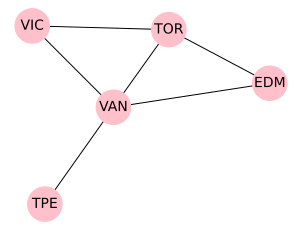

In [3]:
nx.draw(G, **draw_params)

The **degree** of a vertex (or node) refers to the number of edges connected to that vertex. In other words, the degree of a node indicates how many direct relationships it has with other nodes. For example, in a graph representing an airline network, the Vancouver airport has a degree of 4, meaning it is directly connected to four other airports. In contrast, TPE has a degree of 1, as it is connected to only one other airport.

A graph is called **complete** if every pair of vertices is connected by an edge. In a complete graph, each vertex is directly connected to every other vertex, meaning all possible relationships are present. Returning to our airline network example, the graph is not complete because not every airport has a direct flight to every other airport. For instance, there is no direct flight between TOR and TPE, so the graph is incomplete.

Below is an example of a complete graph.

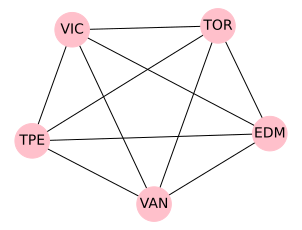

In [4]:
complete_graph = nx.complete_graph(G.nodes)
nx.draw(complete_graph, **draw_params)

```{admonition} Exercise
:class: tip
What is the degree of vertex "VAN" above?

**A.** 0 

**B.** 1 

**C.** 4 

**A.** 5 
```

A **path** is defined as a sequence of edges that connect a sequence of distinct nodes. A graph is said to be **connected** if there exists a path between every pair of nodes. In other words, in a connected graph, you can start at any vertex and reach any other vertex through a sequence of edges.

If there is at least one pair of nodes between which no path exists, the graph is considered **disconnected**. 

Below is an example of a disconnected graph, where some nodes are isolated from others, meaning no path connects them.

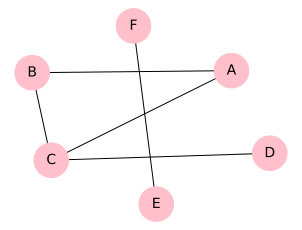

In [5]:
disconnected_graph = nx.Graph()

disconnected_graph.add_node("A")
disconnected_graph.add_node("B")
disconnected_graph.add_node("C")
disconnected_graph.add_node("D")
disconnected_graph.add_node("E")
disconnected_graph.add_node("F")

disconnected_graph.add_edge("A", "B")
disconnected_graph.add_edge("A", "C")
disconnected_graph.add_edge("D", "C")
disconnected_graph.add_edge("B", "C")

disconnected_graph.add_edge("E", "F")

pos = nx.spring_layout(disconnected_graph, k=10)
nx.draw(disconnected_graph, pos, **draw_params)

### 1.2. Graph types: undirected and directed

Graphs can vary in how they represent relationships between their vertices, and understanding these different types is crucial for selecting the right model to solve a given problem. Two fundamental categories of graphs are undirected and directed graphs. These categories reflect whether the connections (edges) between vertices are bidirectional or directional.

#### Undirected Graphs

In many cases, relationships between entities are **bidirectional** or **symmetric**, which means that if there is a connection from one entity to another, the reverse connection also holds. This kind of relationship is modeled by an undirected graph.

In an undirected graph, the edges do not have any direction. For instance, if there is an edge between node A and node B, it means you can traverse from A to B and from B to A without distinction. This is often the case in social networks like Facebook, where a friendship is mutual, or in undirected road systems where vehicles can travel both ways on certain roads.

#### Directed graphs

However, in many other scenarios, the relationship between entities is **directional** or **asymmetric**. For example, on Twitter, you may follow someone without them following you back. This creates an asymmetric relationship that we can model using a directed graph, where each edge has a specific direction.

In a directed graph, each edge points from one node to another. We typically represent these edges with arrows to show the flow of direction. For instance, an arrow from A to B indicates a relationship that goes from A to B, but not necessarily the other way around.

In NetworkX, directed graphs are created using the `DiGraph()` function. Here's an example of adding a directed edge:


In [6]:
G = nx.DiGraph()

G.add_node("Alice")
G.add_node("Bob")
G.add_node("Cal")

G.add_edge("Alice", "Bob")
G.add_edge("Cal", "Alice")
G.add_edge("Cal", "Bob")

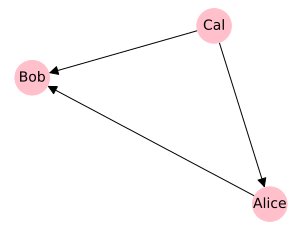

In [7]:
nx.draw(G, **draw_params)

Now let's reverse the direction of the edge from "B" to "C":

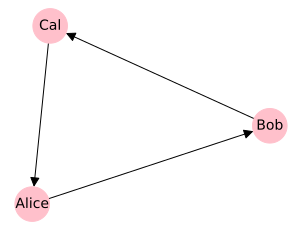

In [8]:
G = nx.DiGraph()

G.add_node("Alice")
G.add_node("Bob")
G.add_node("Cal")

G.add_edge("Alice", "Bob")
G.add_edge("Cal", "Alice")
G.add_edge("Bob", "Cal")

nx.draw(G, **draw_params)

These two graphs are fundamentally different. 

The choice of graph type depends on the situation you're modelling. For example, the graph below shows the MDS prerequisite, which is a directed graph. (Note that this is a directed graph, NOT a tree, because nodes can have multiple parents.)

<img src="mds.png" width="900">



Directed graphs can also have bidirectional connections:

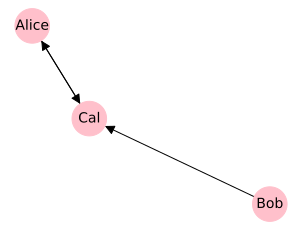

In [9]:
G = nx.DiGraph()

G.add_node("Alice")
G.add_node("Bob")
G.add_node("Cal")

G.add_edge("Bob", "Cal")

# add a 2-way edge
G.add_edge("Cal", "Alice")
G.add_edge("Alice", "Cal")

nx.draw(G, **draw_params)

Here, we have a double-headed arrow between A and C. 

Note that in an undirected graph, it wouldn't have made sense to have both 
```python
G.add_edge("C", "A")
G.add_edge("A", "C")
```
because one would be sufficient.

Directed graphs also can have **self-connections**. However, `networkx` supports self-connections but it doesn't draw them properly. You will see these when getting to Markov chains in DSCI 575.


```{admonition} Exercise
:class: tip
Suppose you have a list of film actors, and you want to keep track of which actors have been in a film together. Would you model that with a directed or undirected graph?

**A.** Directed 

**B.** Undirected 
```

### 1.3. Graph types: unweighted and weighted

In addition to directionality, graphs can also differ based on whether or not the edges have weights. The weight of an edge can represent various quantities such as distance, cost, or capacity. Depending on the problem you're trying to solve, it may be essential to take these weights into account when analyzing the graph. This leads us to the distinction between unweighted and weighted graphs, both of which can be either directed or undirected.

#### Unweighted graphs

The graphs we’ve discussed so far are unweighted, meaning that all edges are treated equally. In an unweighted graph, an edge simply indicates whether or not a relationship exists between two nodes—there is no additional information associated with that edge. 

For example, in an unweighted graph representing an airline network, the presence of an edge between two airports indicates that there is a direct flight between them, but no further details (such as the distance or cost) are considered.

#### Weighted graphs

In contrast, both undirected and directed graphs can have weighted edges, where each edge is assigned a numerical value or weight. This weight conveys extra information about the relationship between two nodes. 

The weight tells us some **numerical information about the relationship**:
- In an airline network, the weight might represent the flight time between two airports or the cost of a flight.
- In a social network, the weight could reflect how long two people have been friends or how frequently they interact.

Weighted graphs allow for more detailed modeling of relationships, making them particularly useful for problems involving optimization, such as [finding the shortest path](https://en.wikipedia.org/wiki/Shortest_path_problem).

Here's an example of an undirected and weighted graph representing the cost to fly between two airports:

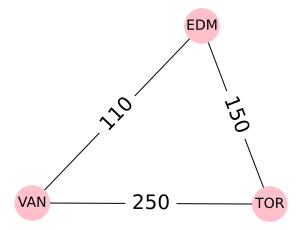

In [10]:
G = nx.Graph()

G.add_node("VAN")
G.add_node("EDM")
G.add_node("TOR")

G.add_edge("VAN", "EDM", weight=110)
G.add_edge("VAN", "TOR", weight=250)
G.add_edge("TOR", "EDM", weight=150)

pos = nx.spring_layout(G)
nx.draw(G, pos, **draw_params)
labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels, font_size=20);

Here's an example of a directed and weighted graph representing the time to fly a particular direction between two airports:

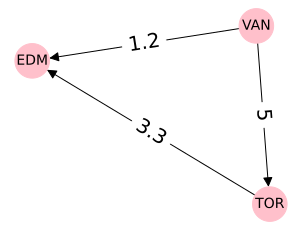

In [11]:
G = nx.DiGraph()

G.add_node("VAN")
G.add_node("EDM")
G.add_node("TOR")

G.add_edge("VAN", "EDM", weight=1.2)
G.add_edge("VAN", "TOR", weight=5)
G.add_edge("TOR", "EDM", weight=3.3)

pos = nx.spring_layout(G)
nx.draw(G, pos, **draw_params)
labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels, font_size=20);

## 2. Graph representations

There are two standard ways to represent a graph $G=(V,E)$ as a collection of adjacency lists or as an adjacency matrix. These representations can be applied to both directed and undirected graphs.

#### Adjacency List Representation

We can represent the graph as an array of **adjacency list**: for each vertex $u$, we have an adjacency list contains all the vertices $v$ such that there is an edge $(u,v)\in E$. That is, it lists all pairs of vertices that are connected to $u$ by an edge. 

The graph below can be represented as the following adjecency list

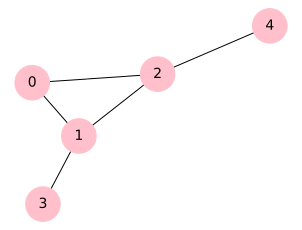

In [12]:
G4 = nx.bull_graph()
nx.draw(G4, **draw_params)

In [13]:
# Get the adjacency list as a dictionary
adj_list_dict = {node: list(neighbors) for node, neighbors in G4.adjacency()}
print(adj_list_dict)

{0: [1, 2], 1: [0, 2, 3], 2: [0, 1, 4], 3: [1], 4: [2]}


```{admonition} Exercise
:class: tip
What is the space complexity of an adjacency list, in terms of $V$, the number of vertices, and $E$, the number of edges?

**A.** $O(V)$

**B.** $O(E)$

**C.** $O(VE)$

**D.** $O(V+E)$ 
```

#### Adjacency Matrix Representation

The adjacency-matrix representation of a graph $G=(V,E)$ assumes that the vertices are numbered $1,2,\dots,|V|$ in some arbitrary manner. Then the adjacency matrix representation of a graph $G$ consists of a $|V| \times |V|$ matrix $A$ such that

$$a_{i,j} = 
\begin{cases}
1,\ \text{if } (i,j) \in E \\
0,\ \text{otherwise}.
\end{cases}$$

In this matrix, a value of $1$ indicates the presence of an edge between vertex $i$ and vertex $j$, while a value of $0$ indicates that no edge exists between these vertices.

Using the same graph G4, the adjacency matrix representation of G4 is:

In [14]:
adj = nx.adjacency_matrix(G4).toarray()
print(adj)

[[0 1 1 0 0]
 [1 0 1 1 0]
 [1 1 0 0 1]
 [0 1 0 0 0]
 [0 0 1 0 0]]


In [15]:
# adjacent matrix for node 0 
adj[0, :]

array([0, 1, 1, 0, 0])

In [16]:
# adjacent matrix between node 1 and 3
adj[1, 3]

1

```{admonition} Exercise
:class: tip
What is the space complexity of an adjacency matrix, in terms of $V$, the number of vertices, and $E$, the number of edges?

**A** $O(VE)$

**B** $O(E^2)$

**C** $O(V^2)$

**D** $O(V+E)$ 
```

#### Comparing two representations:

When choosing between the adjacency matrix and the adjacency list, it's important to consider their respective advantages and disadvantages.

The adjacency matrix is straightforward and intuitive, making it easy to visualize the connections between nodes, especially in small graphs. However, a significant drawback is that most cells in the adjacency matrix will contain zeros, indicating no connections. This leads to several implications:

- Space complexity: $O(V^2)$. 
- Lookup Time: Checking if any two nodes $i$ and $j$ are connected can be done in $O(1)$ time.

On the other hand, the adjacency list implementation provides a more compact representation, particularly suited for sparse graphs. The advantage of the adjacency list implementation is that it allows us to compactly represent a sparse graph. The adjacency list also allows us to easily find all the edges that are directly connected to a particular vertex.

- Space complexity: $O(V+E)$. In the worst case of a complete graph, where every vertex is connected to every other vertex, $E=O(V^2)$, making the space requirements similar to that of an adjacency matrix.
- Lookup Time: However, checking if any two nodes are connected takes $O(V)$ time in the worst case.

Wouldn't it be great if we could combine the lookup speed of the adjacency matrix with the storage efficiency of the adjacency list? While we can't achieve both perfectly, we can come close by using structured adjacency lists, which lead us to the sparse matrices we talked about last week. Sparse matrices allow us to efficiently store and manage connections in a way that balances lookup speed and memory usage.

In fact, `nx` uses sparse matrix to store the adjacency matrix:

In [17]:
am_matrix = nx.adjacency_matrix(G4)
type(am_matrix)

scipy.sparse._csr.csr_array

```{admonition} Exercise
:class: tip
If $|E|$ is much less than $|V^2|$, which representation is better?

**A.** Adjacency list 

**B.** Adjacency matrix 
```

**Answer:** The adjacency list takes up less space, but lookup is slower.

## 3. Breadth-first search

When we model data as a graph, we have to search through the graph to address various questions, such as:
- Is there a path between all vertices? or is the graph connected?
    - For example, "Can I fly from Taipei to Honolulu?"
- What is the shortest distance between two particular vertices?
  - For example, "What is the quickest path (fewest transfers) from Honolulu to Taipei?"
  - For example, "What is the least expensive path from Honolulu to Taipei?"

In this section, we will introduce the first algorithm for searching through graphs: Breadth-First Search (BFS).

We have seen the graph below: 

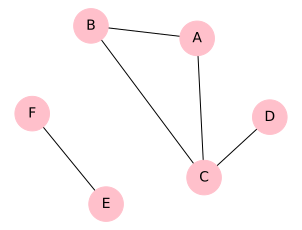

In [18]:
nx.draw(disconnected_graph, pos=nx.spring_layout(disconnected_graph, k=10, seed=5), **draw_params)

In this case, we can visually check whether nodes $A$ and $E$ are connected easily. However, imagine a dataset with millions of nodes and billions of edges, like a Facebook social network you will explore in Lab 3. We can't "eyeball" whether two nodes are connected. We need an **algorithm**.

Breadth-first search (BFS) is one of the simplest algorithms for searching a graph. It also serves as a prototype for several other important graph algorithms that you might encounter in the future. Given a graph $G=(V,E)$ and a starting vertex $s$, BFS proceeds by exploring the edges of the graph to find all the vertices in that can be reached from  $s$. 

Initially, all the vertices are marked as "undiscovered". BFS expands the frontier between discovered and undiscovered vertices uniformly across the breadth of the frontier.  It ensures that all nodes at the current distance from the starting node are explored before moving on to nodes at the next distance.

We can implement BFS iteratively using `queue.Queue`. The algorithm begins with the starting node $s$ and adds its neighbors to the queue. Then, we repeatedly dequeue the next node from the queue to visit. Each time we visit an "unvisited" node, we enqueue its unvisited neighbors. This process guarantees that all "distance 1 neighbors" are visited before any "distance 2 neighbors."

Moreover, BFS can be used to determine the "distance" between nodes by keeping track of the "neighbor depth." This depth indicates how far away a node is from the starting node $s$.

The function below implements BFS to check if `node1` and `node2` are connected:

In [19]:
def check_connected_using_bfs(g, node1, node2, verbose=False):
    """ 
    Given a NetworkX Graph g, and start node node1 
    and goal node node2, tests whether node1 and node2
    are connected in the graph g using breadth first search.
    If they are not connected, returns False.

    Parameters
    ----------
    g : networkx.classes.graph.Graph
        the graph
    node1 : str, int
        first node
    node2 : str, int
        second node
    verbose : bool
        if True, node location will be displayed while False will not
        (default is False)
    
    Returns
    -------
    bool 
        True if the two nodes are connected and False otherwise     

    Example
    --------
    >>> graph = nx.erdos_renyi_graph(2, 1)
    >>> check_connected_using_bfs(graph, 1, 0)
    True
    """
    
    q = queue.Queue()
    q.put(node1)

    visited = {node1}

    while not q.empty():
        v = q.get()
        
        if verbose:
            print("At node", v)
            
        if v == node2:
            return True

        for neighbor in g.neighbors(v):
            if neighbor in visited:
                continue
            visited.add(neighbor)
            q.put(neighbor)

    return False

Let's generate a new graph.

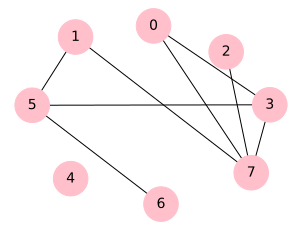

In [20]:
erg = nx.erdos_renyi_graph(8, 0.2, seed=40)
nx.draw(erg, **draw_params, pos=nx.spring_layout(erg, k=14, seed=5))

We can check whether note 5 and note 0 are connected using the function.

In [21]:
check_connected_using_bfs(erg, 5, 0, verbose=True)

At node 5
At node 1
At node 3
At node 6
At node 7
At node 0


True

We will draw out the algorithm process in class.

We can use `networkx` to get the edges encountered during a breadth-first search starting from a specific node, you can use the following code:

In [22]:
print(list(nx.bfs_edges(erg, 5)))

[(5, 1), (5, 3), (5, 6), (1, 7), (3, 0), (7, 2)]


## 4. Depth-first search

As its name suggests, Depth-First Search (DFS) explores deeper into the graph whenever possible. DFS prioritizes exploring edges that lead out from the most recently discovered vertex $v$ that still has unexplored edges.

One way to convert the BFS algorithm into a DFS is by changing the data structure from a `Queue` to a `Stack`. This adjustment allows DFS to backtrack when it reaches a dead end, exploring deeper paths before returning to previous vertices. 

In [23]:
def check_connected_using_dfs(g, node1, node2, verbose=False):
    """ 
    Given a NetworkX Graph g, and start node node1 
    and goal node node2, tests whether node1 and node2
    are connected in the graph g using depth first search.
    If they are not connected, returns False.

    Parameters
    ----------
    g : networkx.classes.graph.Graph
        the graph
    node1 : str, int
        first node
    node2 : str, int
        second node
    verbose : bool
        if True, node location will be displayed while False will not
        (default is False)
    
 
    Returns
    -------
    bool 
        True if the two nodes are connected and False otherwise     

    Example
    --------
    >>> graph = nx.erdos_renyi_graph(2, 1)
    >>> check_connected_using_dfs(graph, 1, 0)
    True
    """
    
    stack = [node1]  # Initialize the stack with the starting node
    
    visited = {node1}

    while stack:
        v = stack.pop()  # Get the last node added to the stack
        
        if verbose:
            print("At node", v)
            
        if v == node2:
            return True
        
        for neighbor in g.neighbors(v):
            if neighbor in visited:
                continue
            visited.add(neighbor)
            stack.append(neighbor) # Add neighbor to the stack

    return False

We can apply the same function to the same graph:

In [24]:
check_connected_using_dfs(erg, 5, 0, verbose=True)

At node 5
At node 6
At node 3
At node 7
At node 2
At node 0


True

We can see that the order is different from BFS. 

Again `networkx` provides the following functions:

In [25]:
print(list(nx.dfs_edges(erg, 5)))

[(5, 1), (1, 7), (7, 0), (0, 3), (7, 2), (5, 6)]


#### Difference between BFS and DFS

|                  | BFS         | DFS         |
|------------------|-------------|-------------|
| Data structure   | Queue       | Stack       |
| Time Complexity  | $O(V+E)$    | $O(V+E)$    | 
| Space Complexity | $O(V)$      | $O(V)$      | 


Both algorithms traverse each vertex and edge once, resulting in similar time complexity. Both algorithms also have the same worse-case space complexity. However, BFS often require more memory, especially in wide graphs, as it holds all nodes in the current frontier. In contrast, DFS holds only the nodes in the current path, which typically requires less space.


## 5. PageRank

In the digital age, the volume of information available on the internet can make it challenging to determine the relevance and importance of different webpages. This leads us to a fundamental question: Which is the most "important" webpage? For example, in a given network, is it page $0$ or page $1$ that holds more significance?

This is a problem known as [centrality](https://en.wikipedia.org/wiki/Centrality), which aim to measures the importance of a node within a graph. A related idea is that of a [hub](https://en.wikipedia.org/wiki/Hub_(network_science)), which refers to nodes that connect to many other nodes. 

One of the most famous measures of centrality is [PageRank](https://en.wikipedia.org/wiki/PageRank), the algorithm that propelled Google to become the leading search engine. PageRank evaluates the importance of webpages based on the links between them, creating a dynamic model of web connectivity.

In this model, we represent websites as nodes in a directed graph. We create a directed edge from site $A$ to site $B$ if site $A$ includes a hyperlink to site $B$. This structure allows us to analyze the web as a graph of pages.

PageRank has a specific mathematical definition, and finding it involves a beautiful application of linear algebra. However, exploring the mathematical intricacies of PageRank is beyond our current scope.

Instead, we can approximate PageRank using a Monte Carlo method with a "simulated web surfer." The process is as follows:
1. We start at a random node (representing a random webpage).
2. With probability $\alpha$, choose a completely random node in the graph, simulating a user visiting a new page. With probability $(1−\alpha)$, choose a random neighbor of the current node, simulating a user clicking on a hyperlink.
3. Repeat Step 2 for $n$ iterations.
4. The ranking of each node is determined by the frequency of visits during this random walk, reflecting its relative importance in the network.

It's important to note that this method is not how Google computes PageRank; the actual algorithm is more elegant and efficient. However, this simulation provides an intuitive way to grasp the concept of PageRank and its implications for understanding the web's structure.


This is an example graph:

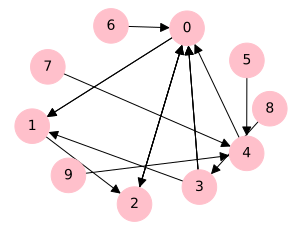

In [26]:
sfg = nx.scale_free_graph(10, seed=20)
nx.draw(sfg, **draw_params, pos=nx.spring_layout(sfg, k=5, seed=1))

We implemented the page rank as follows:

In [27]:
def page_rank(G, alpha=0.1, iters=100_000):
    """
    Compute the PageRank for all nodes in the directed graph G.
    Returns a dictionary of the PageRank for all nodes.

    Parameters
    ----------
    G : networkx.classes.graph.DiGraph
        the graph
    alpha : float
        the probability of surfing to a random page
    iters : int
        the number of iterations of simulation to perform

    Returns
    -------
    collections.Counter 
        A dictionary containing the PageRank for each node.

    Example
    --------
    >>> pr = page_rank(nx.scale_free_graph(3))
    Counter({2: 33349, 0: 33371, 1: 33280})
    """
    visited = Counter()

    nodes = G.nodes()
    # start at a random node
    current_node = np.random.choice(nodes)  
    for i in range(iters):
        if np.random.random() < alpha: 
            # with probability p, go to a random node
            current_node = np.random.choice(nodes)  
        else: 
            # with probability 1-p, go to a random neighbour
            current_node = np.random.choice(list(G.neighbors(current_node)))
        # keep score whenever you visit a node
        visited[current_node] += 1 

    return visited

In [28]:
pr = page_rank(sfg)

In [29]:
pr.most_common()

[(0, 36851),
 (2, 34219),
 (1, 18431),
 (4, 3682),
 (3, 1863),
 (6, 1050),
 (7, 1035),
 (5, 959),
 (9, 956),
 (8, 954)]

We observe that node $0$ has the highest PageRank, which aligns with our expectations. 

##### But why does node 2 rank higher than node 4?
Since node $0$ is the most influential node, having a direct link from node $0$ to node $2$ significantly increases the ranking. There is no direct path from node $0$ to node $4$, meaning node $4$ is not benefitting from the influence of the most popular page. This shows that a link from a popular page is more valuable than a link from a lesser-known or isolated page.

In other words, the quality of incoming links matters more than their quantity. If we were to sort the pages simply by the number of incoming links, we would get a different (and often worse) ranking. The code below sorts the pages by the number of incoming links:

In [30]:
num_neigh = {i: len(list(nx.reverse_view(sfg).neighbors(i)))
             for i in sfg.nodes()}
for node in sorted(num_neigh, key=num_neigh.get, reverse=True):
    print("Node", node, "has", num_neigh[node], "incoming links")

Node 0 has 4 incoming links
Node 4 has 3 incoming links
Node 1 has 2 incoming links
Node 2 has 2 incoming links
Node 3 has 1 incoming links
Node 5 has 0 incoming links
Node 6 has 0 incoming links
Node 7 has 0 incoming links
Node 8 has 0 incoming links
Node 9 has 0 incoming links


With the ranking, we get node $4$ above nodes $1$ and $2$.

#### Optional note: sources of randomness in PageRank

In the context of the PageRank algorithm, there are two sources of randomness:

- Inherent probabilistic nature: The model is fundamentally probabilistic, particularly when we use the probability $\alpha$ to decide whether to follow a link to a neighboring node or jump to a completely random node. This randomness is an integral part of how PageRank is defined.

- Limitations of the Simulation: The simulation introduces randomness as well, specifically through its initialization at one random node and the finite number of iterations performed. This means that the results can vary depending on the starting point and the number of steps taken in the random walk.

These two sources of randomness are quite different. While the first is a core aspect of the PageRank definition and contributes to its effectiveness, the second is a limitation that can affect the accuracy of the results. In fact, it is mathematically possible to calculate the true PageRank for a given network, which addresses the limitations posed by the simulation's finite iterations.

You may encounter similar concepts regarding randomness and probabilistic models in your statistics courses.

## (Optional) 6. Other graph properties 

There are a lot of standard problems in graph theory, not covered in this course, such as:

- Find the largest [clique](https://en.wikipedia.org/wiki/Clique_(graph_theory)) in a graph.
- Find the largest [independent set](https://en.wikipedia.org/wiki/Independent_set_(graph_theory)) in a graph.
- Find the [vertex cover](https://en.wikipedia.org/wiki/Vertex_cover) of a graph with the smallest number of vertices.
- Find the smallest [dominating set](https://en.wikipedia.org/wiki/Dominating_set) in a graph.
- [Colour](https://en.wikipedia.org/wiki/Graph_coloring) a graph with the smallest number of colours.

It turns out a lot of real-world problems can be mapped to these problems, and thus solving these problems is important. **However**, some of the problems are [NP-Complete](https://www.geeksforgeeks.org/np-completeness-set-1/). That is, we don't have fast algorithms to solve these problems. 